

TODO:

- Mirar bien parámetros a configurar
- Visualizar progreso del algoritmo
- Poder introducir variables de entorno a parte de variables de decisión
- Definir función de fitness

In [25]:
import copy
# print all arguments from pygad.GA
import inspect

import pandas as pd
import pygad

method_args = inspect.getfullargspec(pygad.GA)[0]
method_defaults = inspect.getfullargspec(pygad.GA).defaults

for method_arg, def_value in zip(method_args, method_defaults):
    print(f"{method_arg}: {def_value}")

self: None
num_generations: None
num_parents_mating: None
fitness_func: None
fitness_batch_size: -4
initial_population: 4
sol_per_pop: <class 'float'>
num_genes: sss
init_range_low: -1
init_range_high: 1
gene_type: 3
parent_selection_type: single_point
keep_parents: None
keep_elitism: random
K_tournament: None
crossover_type: False
crossover_probability: default
mutation_type: None
mutation_probability: -1.0
mutation_by_replacement: 1.0
mutation_percent_genes: None
mutation_num_genes: True
random_mutation_min_val: None
random_mutation_max_val: None
gene_space: None
allow_duplicate_genes: None
on_start: None
on_fitness: None
on_parents: None
on_crossover: 0.0
on_mutation: False
on_generation: False
on_stop: False
delay_after_gen: None
save_best_solutions: None
save_solutions: None
suppress_warnings: None


/home/jmserrano/development_psa/SolarMED-optimization/venv/lib/python3.11/site-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/home/jmserrano/development_psa/SolarMED-optimization/venv/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 8.04684790786497
Change     = 8.04684790786497
Generation = 2
Fitness    = 8.04684790786497
Change     = 0.0
Generation = 3
Fitness    = 8.04684790786497
Change     = 0.0
Generation = 4
Fitness    = 8.04684790786497
Change     = 0.0
Generation = 5
Fitness    = 37.358092103275276
Change     = 29.311244195410303
Generation = 6
Fitness    = 51.95480475583817
Change     = 14.596712652562893
Generation = 7
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 8
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 9
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 10
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 11
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 12
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 13
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 14
Fitness    = 51.95480475583817
Change     = 0.0
Generation = 15
Fitness    = 51.95480475583817
Change     = 0.0
Generatio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


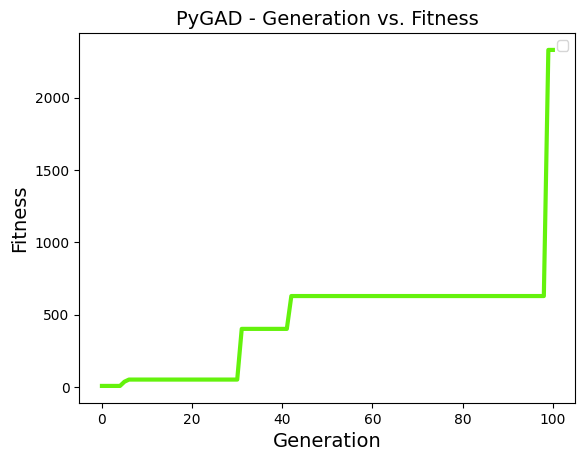

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [ 0.28814905 -5.09913106  0.8196235   3.30715681 -2.94579551  4.07649031]
Fitness value of the best solution = 2329.7518032956095
Index of the best solution : 0
Predicted output based on the best solution : 43.999570769728095
Best fitness value reached after 99 generations.


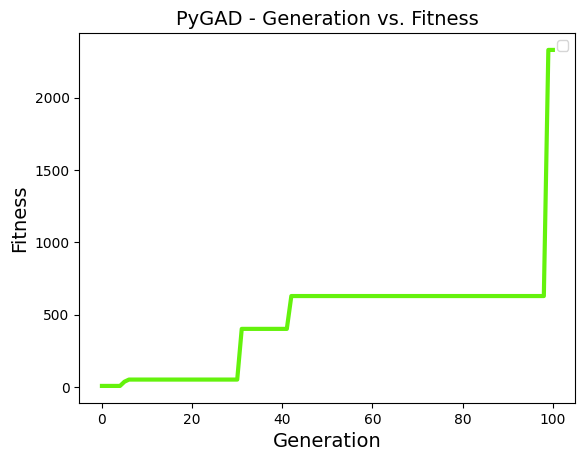

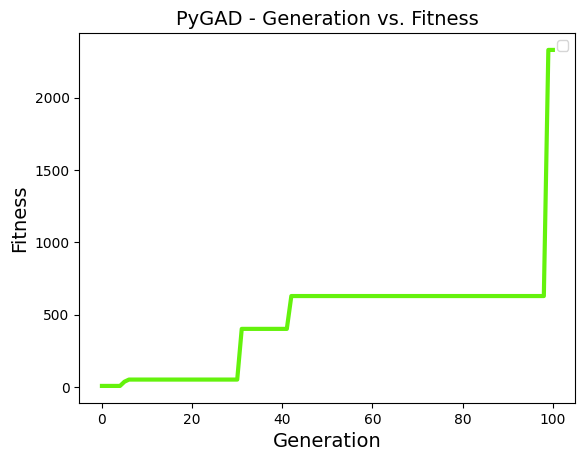

In [1]:
# Project's [example](https://github.com/ahmedfgad/GeneticAlgorithmPython/tree/3.3.1?tab=readme-ov-file#example) on GitHub

import pygad
import numpy

"""
Given the following function:
    y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + 6wx6
    where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44
What are the best values for the 6 weights (w1 to w6)? We are going to use the genetic algorithm to optimize this function.
"""

function_inputs = [4,-2,3.5,5,-11,-4.7] # Function inputs.
desired_output = 44 # Function output.

def fitness_func(ga_instance, solution, solution_idx):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    output = numpy.sum(solution*function_inputs)
    fitness = 1.0 / numpy.abs(output - desired_output)
    return fitness

fitness_function = fitness_func

num_generations = 100 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
sol_per_pop = 50 # Number of solutions in the population.
num_genes = len(function_inputs)

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution()[1]}")
    print(f"Change     = {ga_instance.best_solution()[1] - last_fitness}")
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       on_generation=callback_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()

# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

prediction = numpy.sum(numpy.array(function_inputs)*solution)
print(f"Predicted output based on the best solution : {prediction}")

if ga_instance.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance.best_solution_generation} generations.")

# Saving the GA instance.
filename = 'genetic' # The filename to which the instance is saved. The name is without extension.
ga_instance.save(filename=filename)

# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_fitness()

In [11]:
import pygad
import numpy as np
from solarMED_modeling.solar_med import SolarMED
import os
from solarMED_modeling import MedVacuumState

os.environ["MR"] = f"{os.environ['HOME']}/MATLAB/R2023b"
MR = os.environ["MR"]
os.environ["LD_LIBRARY_PATH"] = f"{MR}/runtime/glnxa64:{MR}/bin/glnxa64:{MR}/sys/os/glnxa64:{MR}/sys/opengl/lib/glnxa64"

In [17]:
init_vars = dict(Tts_h=[], Tts_c=[], Tsf_in_ant=np.array([0]), msf_ant=np.array([0]), resolution_mode="simple")
model = SolarMED(**init_vars)

2024-05-13 10:16:22.332 | INFO     | solarMED_modeling.solar_med:init_matlab_engine:701 - MATLAB engine initialized
2024-05-13 10:16:22.333 | INFO     | solarMED_modeling.solar_med:model_post_init:522 - 
        SolarMED model initialized with: 
            - Evaluating models: True
            - Evaluating finite state machines: False
            - Resolution mode: simple
            - Sample time: 60 s
            - MED actuators: ['med_brine_pump', 'med_feed_pump', 'med_distillate_pump', 'med_cooling_pump', 'med_heatsource_pump']
            - Solar field actuators: ['sf_pump']
            - Thermal storage actuators: ['ts_src_pump']
        


In [13]:
"""
Some nomenclature:

- Genes / decision variables: The variables that are going to be optimized, output of the optimization layer (upper layer in a hierarchical control scheme) and are the setpoints for the low-level control layer.


## SolarMED inputs (copied from the model)

The order is important!

    - mts_src: float,  # Thermal storage decision variables
    - Tsf_out: float,  # Solar field decision variables
    - mmed_s: float, mmed_f: float, Tmed_s_in: float, Tmed_c_out: float, med_vacuum_state: int[0,1,2] | MedVacuumState[OFF,LOW,HIGH] # MED decision variables
    
    - Tmed_c_in: float, Tamb: float, I: float, wmed_f: float = None,  # Environment variables    
-
"""

# Algorithm hyper-parameters
num_generations = 100 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.

# Gene space
# As of Python 3.7: "the insertion-order preservation nature of dict objects has been declared to be an official part of the Python language spec."
# np.arange(start, stop, step)
# np.linspace(start, stop, num=50)

## Thermal storage
mts_src_sol_space = [0]
mts_src_sol_space.extend(np.linspace(start=model.lims_mts_src[0], stop=model.lims_mts_src[1], num=4))
## Solar field
Tsf_out_sol_space = [0]
Tsf_out_sol_space.extend(np.linspace(start=model.lims_Tsf_out[0], stop=model.lims_Tsf_out[1], num=6))
## MED
mmed_s_sol_space = [0]
mmed_s_sol_space.extend(np.linspace(start=model.lims_mmed_s[0], stop=model.lims_mmed_s[1], num=3))
mmed_f_sol_space = np.linspace(start=model.lims_mmed_f[0], stop=model.lims_mmed_f[1], num=4)
Tmed_s_in_sol_space = np.linspace(start=model.lims_Tmed_s_in[0], stop=model.lims_Tmed_s_in[1], num=4)
Tmed_c_out_sol_space = np.linspace(start=model.lims_Tmed_c_out[0], stop=model.lims_Tmed_c_out[1], num=4)
med_vacuum_state_sol_space = [state.value for state in MedVacuumState]

gene_space = [
    # Decision variables. Important to keep order in sync with `step` model's method
    # Options: list of values, dict(low, high, step), 
    mts_src_sol_space, Tsf_out_sol_space, mmed_s_sol_space, mmed_f_sol_space, Tmed_s_in_sol_space, Tmed_c_out_sol_space, med_vacuum_state_sol_space
]

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
sol_per_pop = 100 # Number of solutions/individuals in the population.

# Number of decision variables
num_genes = len(gene_space)

NameError: name 'function_inputs' is not defined

In [ ]:
from pydantic import BaseModel

def fitness_function(ga_instance: pygad.GA, dec_vars: np.ndarray, solution_idx: int) -> float: # acumulated cost

    # Np = env_vars.shape[1]
    # Nc = dec_vars.shape[1] # 0: rows, 1: columns
    Np = ga_instance.additional_vars["Np"]
    Nc = ga_instance.additional_vars["Nc"]
    samples_opt = ga_instance.additional_vars["samples_opt"]
    model_copy = copy.deepcopy(ga_instance.additional_vars["model"])
    
    # Checks
    # costs_w = costs_w if isinstance(costs_w, np.ndarray) else np.ones(1, Np) * costs_w
    # costs_e = costs_e if isinstance(costs_e, np.ndarray) else np.ones(1, Np) * costs_e
    costs_w = ga_instance.additional_vars["cost_vars"].costs_w
    costs_e = ga_instance.additional_vars["cost_vars"].costs_e
    env_vars = ga_instance.additional_vars["env_vars"]
    
    if isinstance(samples_opt, int):
        # Sample rate specified, build vector of samples where decision variables are updated
        samples_opt =  np.zeros(1, Np)
        samples_opt[::samples_opt] = True
    
    if np.sum(samples_opt) != Nc:
        raise ValueError("There should be as many True elements in samples_opt as number of samples to update the decision variables")
    
    # Initialization
    dec_vars_idx = -1
    acum_cost = np.zeros(1, Nc)
    current_dec_vars = None
    
    # Simulate
    df = pd.DataFrame() # TODO: Add dimensions? Is it more efficient than just appending sequentially?
    for idx in range(0, Np):
        # Update decision variables values
        if samples_opt[idx] == True:
            dec_vars_idx += 1
            current_dec_vars = dec_vars[dec_vars_idx]
            
        model_copy.step(
             **current_dec_vars,
             **env_vars[idx],
        )
        
        acum_cost[dec_vars_idx] += model_copy.evaluate_cost(cost_e=costs_e[idx], cost_w=costs_w[idx])
        
        df = model_copy.to_dataframe(df)
    
    total_cost = np.sum(acum_cost)
    
    # Save results if best candidate
    if total_cost < ga_instance.ga_instance.additional_outputs["solution_fitness"]: # Can't we use some property from ga_instance instead of declaring our own `solution_fitness`?
        ga_instance.additional_outputs["df"] = df
        ga_instance.additional_outputs["solution_idx"] = solution_idx
        ga_instance.additional_outputs["solution_fitness"] = total_cost
    
    return total_cost

# def on_fitness(ga_instance: pygad.GA, population_fitness: np.ndarray):
#     """
#     Callback that is evaluated after the fitness function is evaluated for all the population
#     Here we already know the best candidate, since computing the prediction horizon is expensive,
#     can we retrieve its outputs
#     UPDATE: Implemented on the fitness function itself
#     """
#     pass

class EnvVarsSolarMED(BaseModel):
    """
    Simple class to make sure that the required environment variables are passed
    """
    Tmed_c_in: np.ndarray[float] # Seawater temperature
    Tamb: np.ndarray[float]  # Ambient temperature
    I: np.ndarray[float] # Solar radiation
    wmed_f: np.ndarray[float] = None # Seawater flow rate
    
class CostVarsSolarMED(BaseModel):
    """
    Simple class to make sure that the required cost variables are passed
    """
    costs_w: np.ndarray[float] # Water cost
    costs_e: np.ndarray[float] # Electricity cost

In [ ]:
df = pd.DataFrame() # TODO: Load real data
df_mod = pd.DataFrame()
df_list = [] # List of dataframes with the results of the simulation of the prediction horizon on each iteration

idx_start = 0
model_sample_rate = 300 # seconds
opt_sample_rate = 3600 # seconds
prediction_horizon_duration = 24*3600 # seconds
Np = prediction_horizon_duration//model_sample_rate 
default_cost_w = 3 # €/m3
default_cost_e = 0.05 # €/kWh
ga_instance = None

for step_idx in range(idx_start, len(df)-(idx_start+Np)):
    
    # Predict environment variables
    # TODO - For now just use the available data
    
    # Generate decision variables update samples
    # TODO - For now just distribute them uniformly
    samples_opt: np.ndarray[bool] = np.full((1, Np), False, dtype=bool)
    samples_opt[::opt_sample_rate//model_sample_rate] = True
    
    # Setup additional required variables
    env_vars: EnvVarsSolarMED = EnvVarsSolarMED(
        Tmed_c_in=df["Tmed_c_in"].iloc[step_idx:step_idx+Np],
        Tamb=df["Tamb"].iloc[step_idx:step_idx+Np],
        I=df["I"].iloc[step_idx:step_idx+Np],
        wmed_f=df["wmed_f"].iloc[step_idx:step_idx+Np] if "wmed_f" in df.columns else None
    )
    
    cost_vars: CostVarsSolarMED = CostVarsSolarMED(
        costs_w=df["costs_w"].iloc[step_idx:step_idx+Np] if "costs_w" in df.columns else np.full((1, Np), default_cost_w),
        costs_e=df["costs_e"].iloc[step_idx:step_idx+Np] if "costs_e" in df.columns else np.full((1, Np), default_cost_e)
    )
    
    # Initialize the population from the previous step
    if ga_instance is not None:
        # Should retrieve not only the best candidate but the X best candidates, the rest of the population should be randomly generated
        pass
    
    # Update decision variables
    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating, 
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop, 
        num_genes=num_genes,
        gene_space=gene_space,
        on_generation=callback_generation,
        mutation_type="adaptive",
        parallel_processing=["process", 8], 
        save_best_solutions=True,
        keep_elitism=10,
    )
    ga_instance.additional_vars = dict(
        env_vars=env_vars, cost_vars=cost_vars, samples_opt=samples_opt, 
        sample_rate=model_sample_rate, Np=Np, Nc=np.sum(samples_opt), model=model
    )
    ## Reset additional outputs, it should be set at each .run() call
    ga_instance.additional_outputs = dict(df=None, solution_idx=None, solution_fitness=None) 
    
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if step_idx == idx_start:
        ga_instance.summary() # Print summary of the GA instance, only once
        
    # Simulate system with new decision variables
    model.step(**solution[0], **env_vars[0], )
    model.calculate_benefit(**cost_vars[0])
    
    # Retrieve results for the whole prediction horizon from fitness_function evaluation
    if ga_instance.additional_outputs["df"] is None:
        raise ValueError("Dataframe from best solution was not saved in the additional outputs")
    if ga_instance.additional_outputs["solution_idx"] != solution_idx:
        raise ValueError("Solution index from best solution does not match the one from the additional outputs")
    
    df_list.append( ga_instance.additional_outputs["df"] ) # Save results of current and future steps from current iteration
    df_mod = model.to_dataframe(df_mod) # Save results of current step